Code for assigning colors to identified pieces of clothing.

In [22]:
from haishoku.haishoku import Haishoku # for detecting the dominant color
from PIL import Image
import numpy as np
from rembg import remove # for removing background

In [393]:
#!pip install haishoku
#!pip install rembg

In [37]:
TRANSPARENCY_LIMIT=125
BACKGROUND_PERCENTAGE_THRESHOLD=0.8
        
COLOR_DICT = { # some basic color RGBs
"lightgreen":np.array([0, 255, 0]),
"red":np.array([255,0,0]),
"blue":np.array([0,0,255]),
"yellow":np.array([255,255,0]),
"green":np.array([7, 180, 44]),
"purple":np.array([128,0,128]),
"orange":np.array([255, 165, 0]),
"pink":np.array([255, 192, 203]),
"darkpink":np.array([173, 109, 119]),
"lightgray":np.array([200, 200, 200]),
"brown":np.array([123, 63, 0]),
"black":np.array([0,0,0]),
"white":np.array([255,255,255]),
"gray":np.array([128,128,128]),
}

In [48]:
from haishoku import haillow
from haishoku import alg

class HaishokuModifed(Haishoku):
    def __init__(self):
        super().__init__()
    
    def getColorsMean(image):
        # get colors tuple with haillow module
        image_colors = get_colors(image)

        # sort the image colors tuple
        sorted_image_colors = alg.sort_by_rgb(image_colors)

        # group the colors by the accuaracy
        grouped_image_colors = alg.group_by_accuracy(sorted_image_colors)

        # get the weighted mean of all colors
        colors_mean = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    grouped_image_color = grouped_image_colors[i][j][k]
                    if 0 != len(grouped_image_color):
                        color_mean = alg.get_weighted_mean(grouped_image_color)
                        colors_mean.append(color_mean)

        # return the most 8 colors
        temp_sorted_colors_mean = sorted(colors_mean)
        if 8 < len(temp_sorted_colors_mean):
            colors_mean = temp_sorted_colors_mean[len(temp_sorted_colors_mean)-8 : len(temp_sorted_colors_mean)]
        else:
            colors_mean = temp_sorted_colors_mean

        # sort the colors_mean
        colors_mean = sorted(colors_mean, reverse=True)

        return colors_mean
    
    def showPalette(image_path):
        # get the palette first
        palette = HaishokuModifed.getPalette(image_path)

        # getnerate colors boxes
        images = []
        for color_mean in palette:
            w = color_mean[0] * 400
            color_box = haillow.new_image('RGB', (int(w), 20), color_mean[1])
            images.append(color_box)

        # generate and show the palette
        haillow.joint_image(images)

    def showDominant(image_path):
        # get the dominant color
        dominant = HaishokuModifed.getDominant(image_path)

        # generate colors boxes
        images = []
        dominant_box = haillow.new_image('RGB', (50, 20), dominant)
        for i in range(8):
            images.append(dominant_box)

        # show dominant color
        haillow.joint_image(images)


    def getDominant(image_path=None):
        # get the colors_mean
        colors_mean = HaishokuModifed.getColorsMean(image_path)
        colors_mean = sorted(colors_mean, reverse=True)

        # get the dominant color
        dominant_tuple = colors_mean[0]
        dominant = dominant_tuple[1]
        return dominant

    def getPalette(image_path=None):
        # get the colors_mean
        colors_mean = HaishokuModifed.getColorsMean(image_path)

        # get the palette
        palette_tmp = []
        count_sum = 0
        for c_m in colors_mean:
            count_sum += c_m[0]
            palette_tmp.append(c_m)

        # calulate the percentage
        palette = []
        for p in palette_tmp:
            pp = '%.2f' % (p[0] / count_sum)
            tp = (float(pp), p[1])
            palette.append(tp)

        return palette

def get_image(image):
    return image.convert("RGBA")

def get_thumbnail(image):
    image.thumbnail((256, 256))
    return image

def get_colors(image):
    """ image instance
    """
    image = get_image(image)

    """ image thumbnail
        size: 256 * 256
        reduce the calculate time 
    """
    thumbnail = get_thumbnail(image)


    """ calculate the max colors the image cound have
        if the color is different in every pixel, the color counts may be the max.
        so : 
        max_colors = image.height * image.width
    """
    image_height = thumbnail.height
    image_width = thumbnail.width
    max_colors = image_height * image_width

    image_colors = image.getcolors(max_colors)
    image_colors = list(filter(lambda x: x[1][3] > TRANSPARENCY_LIMIT, image_colors))
    image_colors = [(col[0], col[1][:3]) for col in image_colors]
    return image_colors



In [3]:
import datasets
es = datasets.load_dataset("adam-narozniak/clothing") # spanish-labeled dataset for testing
es_train = es["train"]

D:\anaconda\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Generating train split:   0%|          | 0/3332 [00:00<?, ? examples/s]

In [72]:
def get_cloth_color(image, bbox):
    """
    Function that returns the name of the color of a given item of clothing.
    Params:
    image -- original image from which to extract the item of clothing
    bbox -- bounding box including the item of clothing, in a form (x1, y1, x2, y2)
    Returns:
    color -- name of the color of the item of clothing (chosen from a list, see COLOR_DICT)
    """
    image_cropped = get_cloth_from_image(image, bbox) 
    
    img_no_background = remove(image_cropped)
    mask = img_no_background.split()[3]
    if np.sum(np.array(mask)<TRANSPARENCY_LIMIT)/np.prod(np.array(mask).shape) > BACKGROUND_PERCENTAGE_THRESHOLD: # check if background takes more than 80% of image
        final_img = image_cropped # if so, don't remove background
    else:
        final_img = img_no_background
    dominating_color = HaishokuModifed.getDominant(final_img) # get dominating color RGB
    dominating_color = np.array(dominating_color)
    distances = get_distances_from_dominating_color(dominating_color)
    color = list(COLOR_DICT.keys())[distances.index(min(distances))] # get color name that is the closest to the dominating color
    return color

def get_distances_from_dominating_color(dominating_color):
     # calculate distances to some basic colors
    distances = []
    for col_rgb in COLOR_DICT.values(): 
        distances.append(np.linalg.norm(dominating_color-col_rgb))
    return distances
    
    

def get_cloth_from_image(image, bbox):
     # crop image to the bounding box
    x1, y1, x2, y2 = bbox
    image_cropped = image.crop((x1, y1, x2, y2))
    return image_cropped

lightgray


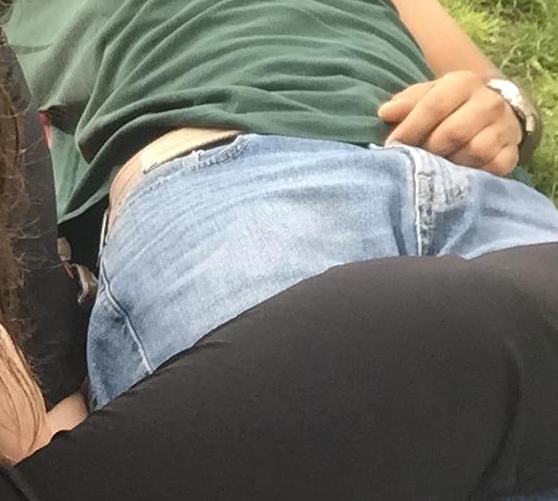

In [73]:
item = 5
bbox = 1
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

[30 27 34]
[(0.68, (30, 27, 34)), (0.18, (225, 223, 220)), (0.1, (128, 120, 122)), (0.02, (99, 65, 59)), (0.01, (183, 148, 134)), (0.01, (75, 75, 90)), (0.0, (109, 89, 79)), (0.0, (172, 166, 175))]
black


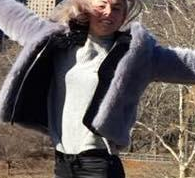

In [69]:
item = 0
bbox = 1
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])) # shadow seems to be interfering
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


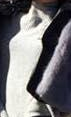

In [398]:
item = 0
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])) # white is the 2nd color detected
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

[32 31 39]
[(0.52, (32, 31, 39)), (0.38, (230, 229, 224)), (0.09, (130, 126, 129)), (0.0, (79, 77, 87)), (0.0, (91, 73, 68)), (0.0, (165, 162, 173)), (0.0, (87, 81, 90)), (0.0, (175, 174, 165))]
black


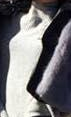

In [67]:
item = 0
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])) # white is the 2nd color detected
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

orange


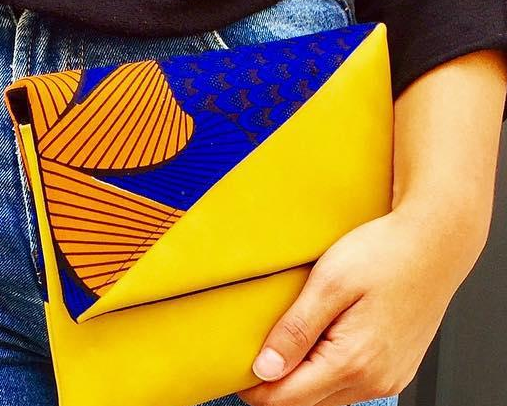

In [399]:
item = 2
bbox = 1
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

orange


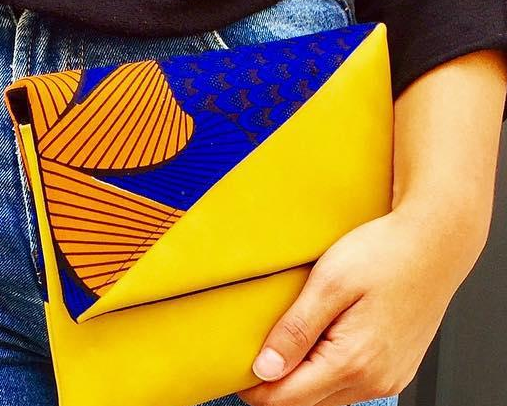

In [54]:
item = 2
bbox = 1
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


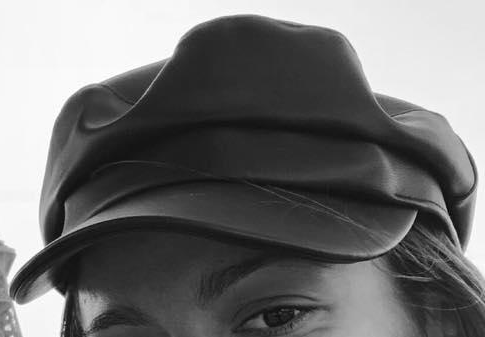

In [400]:
item = 7
bbox = 1
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


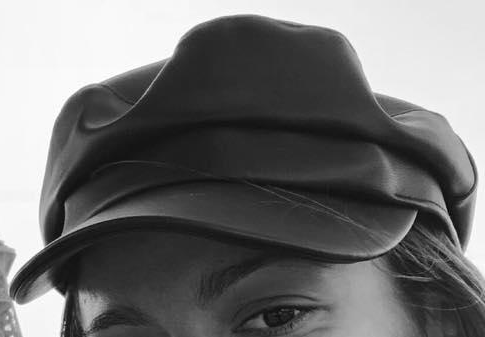

In [55]:
item = 7
bbox = 1
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


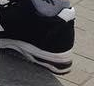

In [401]:
item = 11
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


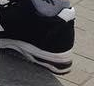

In [56]:
item = 11
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

darkpink


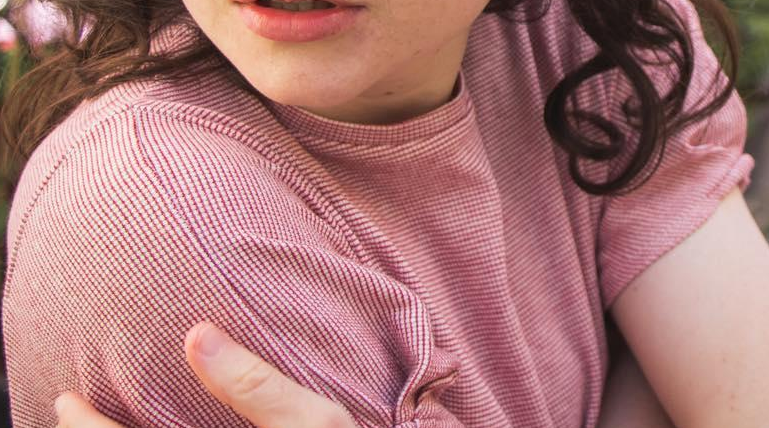

In [402]:
item = 372
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

darkpink


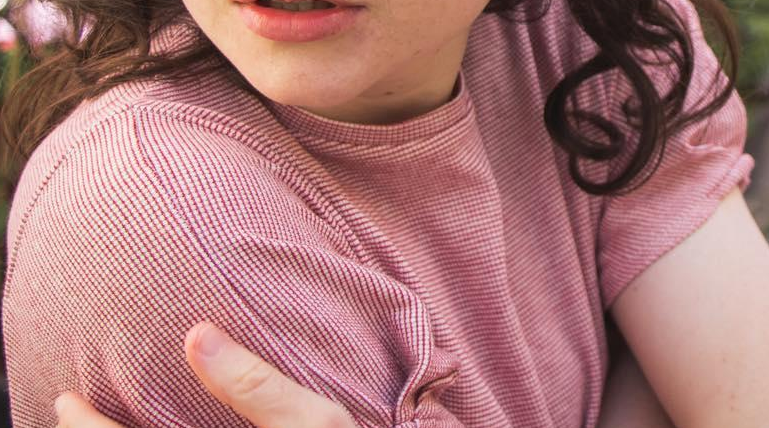

In [57]:
item = 372
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

gray


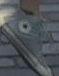

In [403]:
item = 200
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

gray


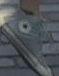

In [58]:
item = 200
bbox = 0
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


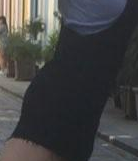

In [404]:
item = 200
bbox = 3
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

black


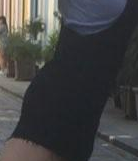

In [59]:
item = 200
bbox = 3
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

lightgray


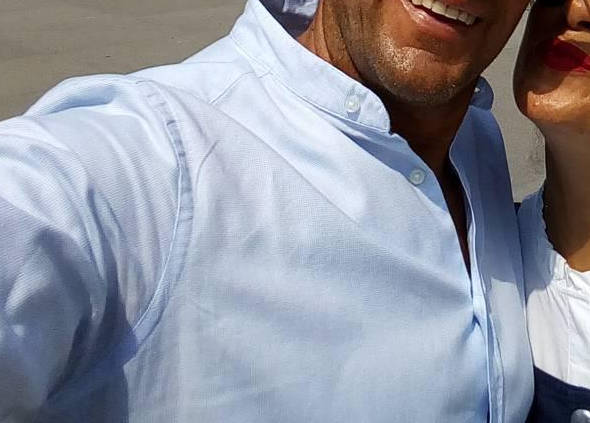

In [405]:
item = 100
bbox = 3
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

lightgray


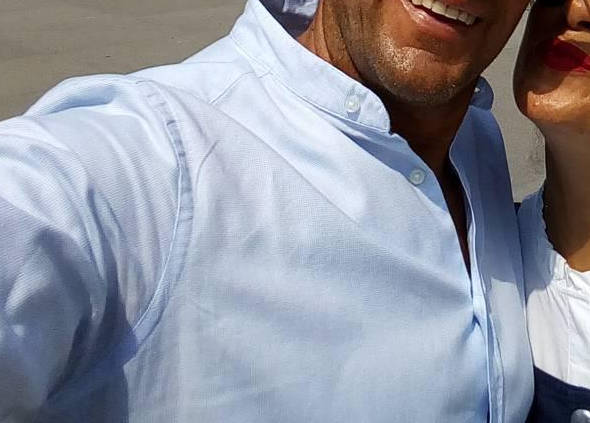

In [60]:
item = 100
bbox = 3
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

lightgray


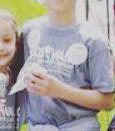

In [422]:
item = 120
bbox = 10
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

lightgray


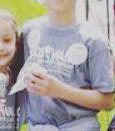

In [61]:
item = 120
bbox = 10
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

darkpink


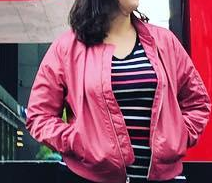

In [425]:
item = 80
bbox = 2
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])

darkpink


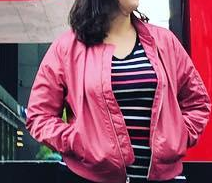

In [62]:
item = 80
bbox = 2
print(get_cloth_color(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox]))
get_cloth_from_image(es_train[item]["image"], es_train[item]['objects']['bbox'][bbox])